# Notebook for the baseline model 
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch import tensor
from sklearn.linear_model import LinearRegression


/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

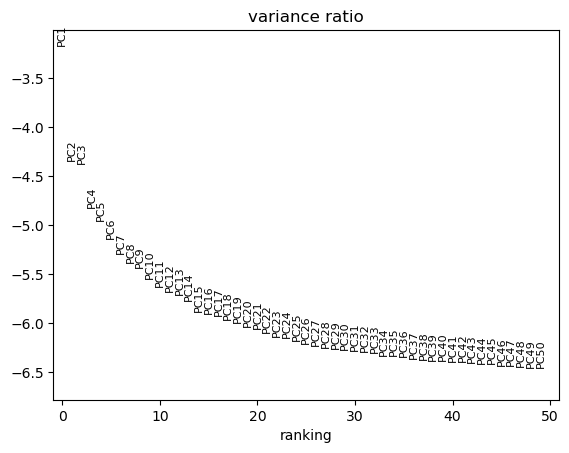

In [4]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

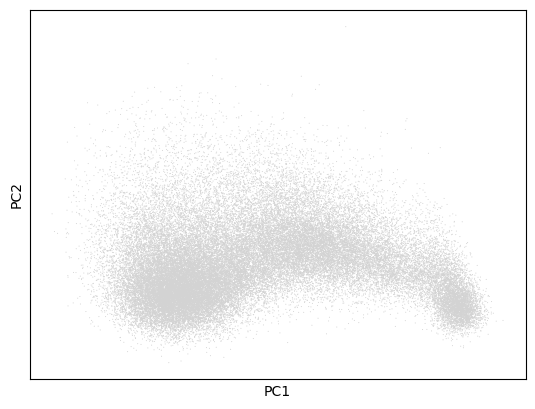

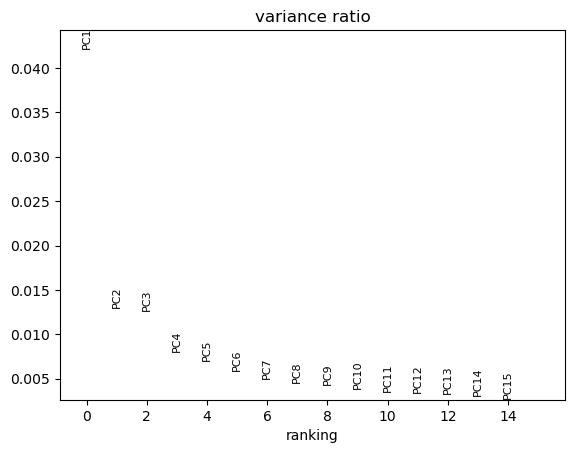

In [5]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [6]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [7]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [8]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X = adata[P1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values    

# Cell Pairing

In [9]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])
p1 = np.array([P1_targets[np.where(P1_clones == cid)[0][0]] if cid in P1_clones else np.nan for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X, s1, t1 = X[valid_indices], s1[valid_indices], t1[valid_indices]
P1_clones = P1_clones[valid_indices]

In [10]:
# get cells per clonotype
clonotype_cell_counts = pd.DataFrame(P1_clones, columns=["Clonotype"]).value_counts().reset_index()
clonotype_cell_counts.columns = ["Clonotype", "Cell Count"]

# Display the counts per clonotype
clonotype_cell_counts

,Clonotype,Cell Count
0,897.0,297
1,926.0,216
2,30.0,160
3,870.0,141
4,171.0,136
...,...,...
3605,2551.0,0
3606,2552.0,0
3607,2553.0,0
3608,2555.0,0


## Split into Train-Val-Test
Split donors between Train & test


In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract donor information and unique clonotypes
donors = adata.obs["donor"].values  # Donor IDs for each cell
unique_clonotypes = np.unique(P1_clones)  # Unique clonotypes in P1

# Map each clonotype to a donor
clonotype_to_donor = {clone: donors[np.where(P1_clones == clone)[0][0]] for clone in unique_clonotypes}

# Extract unique donors
unique_donors = np.unique(list(clonotype_to_donor.values()))

# Split donors into train and test
train_donors, test_donors = train_test_split(unique_donors, test_size=0.2, random_state=42)

# Create masks for train and test clonotypes based on donors
train_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in train_donors]
test_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in test_donors]

# Aggregate features and targets by clone
X_aggregated = []  # Features
y_s1_aggregated = []  # Target values for S1
y_t1_aggregated = []  # Target values for T1

for clone in unique_clonotypes:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    # y_p1_aggregated.append(p1[mask].mean())   # Mean of P1 for the clone
    y_s1_aggregated.append(s1[mask].mean())   # Mean of S1 for the clone
    y_t1_aggregated.append(t1[mask].mean())   # Mean of T1 for the clone

# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)

# Create masks for train and test sets
train_mask = np.isin(unique_clonotypes, train_clonotypes)
test_mask = np.isin(unique_clonotypes, test_clonotypes)

# Split aggregated data into train and test sets
X_s1_train, X_s1_test = X_aggregated[train_mask], X_aggregated[test_mask]
X_t1_train, X_t1_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]





'# Aggregate features and targets by clone\nX_aggregated = []  # Features\ny_s1_aggregated = []  # Target values for S1\ny_t1_aggregated = []  # Target values for T1\ny_p1_aggregated = []  # Target values for P1\n\nfor clone in unique_clonotypes:\n    mask = P1_clones == clone  # Select rows matching the current clone\n    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features\n    # y_p1_aggregated.append(p1[mask].mean())   # Mean of P1 for the clone\n    y_s1_aggregated.append(s1[mask].mean())   # Mean of S1 for the clone\n    y_t1_aggregated.append(t1[mask].mean())   # Mean of T1 for the clone\n\n# Convert lists to arrays\nX_aggregated = np.array(X_aggregated)\ny_s1_aggregated = np.array(y_s1_aggregated)\ny_t1_aggregated = np.array(y_t1_aggregated)\n\n# Create masks for train and test sets\ntrain_mask = np.isin(unique_clonotypes, train_clonotypes)\ntest_mask = np.isin(unique_clonotypes, test_clonotypes)\n\n# Split aggregated data into train and test sets\nX_s1_train, X_s1_tes

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# Extract donor information and unique clonotypes
donors = adata.obs["donor"].values  # Donor IDs for each cell
unique_clonotypes = np.unique(P1_clones)  # Unique clonotypes in P1
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []


# Map each clonotype to a donor
clonotype_to_donor = {clone: donors[np.where(P1_clones == clone)[0][0]] for clone in unique_clonotypes}

# Extract unique donors
unique_donors = np.unique(list(clonotype_to_donor.values()))

# Split donors into train and test
train_donors, test_donors = train_test_split(unique_donors, test_size=0.2, random_state=42)

# Create masks for train and test clonotypes based on donors
train_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in train_donors]
test_clonotypes = [clone for clone, donor in clonotype_to_donor.items() if donor in test_donors]

# Create masks for train, test, and eval sets based on clonotypes
train_mask = np.isin(unique_clonotypes, train_clonotypes)
test_mask = np.isin(unique_clonotypes, test_clonotypes)


# Step 2: Aggregate features and P1 data for training (train using clonotype-level data)
for clone in unique_clonotypes:
    mask = P1_clones == clone  # Select rows matching the current clone
    X_aggregated.append(X[mask].mean(axis=0))  # Mean of features
    y_s1_aggregated.append(s1[mask].mean())      # Mean of s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of t1 for the clone


# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)

# Split aggregated data into train and test sets
X_s1_train, X_s1_test = X_aggregated[train_mask], X_aggregated[test_mask] # TODO differ in S1 and T1 here? 
X_t1_train, X_t1_test = X_aggregated[train_mask], X_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]


In [20]:
# Step 1: Train the model using both s1 and p1 as features
model_s1 = LinearRegression()
model_s1.fit(X_s1_train, y_s1_train)  # Train the model using s1 and p1 features to predict s1

# Step 2: Make predictions on the test set
y_s1_pred = model_s1.predict(X_s1_test)

# Step 3: Calculate MSE on clonotype level for the test set
mse_test = mean_squared_error(y_s1_test, y_s1_pred)
# TODO recall per clono?
print(f"Clonotype-level MSE (Test Set): {mse_test}")


Clonotype-level MSE (Test Set): 0.029967928017819234


In [21]:
import torch

# Assuming the model `model_s1` has already been trained and is available

# Function to compute KL divergence
def general_kl_loss(mu_1, logvar_1, mu_2, logvar_2):
    kl = logvar_2 - logvar_1 + torch.exp(logvar_1) / torch.exp(logvar_2) + (mu_1 - mu_2) ** 2 / torch.exp(logvar_2) - 1
    kl = 0.5 * torch.sum(kl)
    return kl

# Compute KL divergence per donor based on aggregated test set
for donor in test_donors:
    # Get the indices of the clonotypes associated with the current donor
    donor_clonotypes = [clone for clone, donor_id in clonotype_to_donor.items() if donor_id == donor]
    
    # Get the feature and target data for the current donor's clonotypes
    donor_mask = np.isin(unique_clonotypes, donor_clonotypes)  # Mask for test clonotypes of this donor
    X_donor_test = X_aggregated[donor_mask]
    y_s1_donor_test = y_s1_aggregated[donor_mask]  # True S1 responses for this donor
    y_t1_donor_test = y_t1_aggregated[donor_mask]  # True T1 responses for this donor
    
    # Predict responses using the model for this donor
    y_s1_pred_donor = model_s1.predict(X_donor_test)  # Predicted S1 responses
    
    # Compute the means and log-variances for KL divergence
    mu_1 = torch.tensor(y_s1_donor_test.mean())  # Mean of true S1 responses
    logvar_1 = torch.tensor(np.log(np.var(y_s1_donor_test) + 1e-6))  # Log variance of true responses (adding small value to avoid log(0))
    
    mu_2 = torch.tensor(y_s1_pred_donor.mean())  # Mean of predicted S1 responses
    logvar_2 = torch.tensor(np.log(np.var(y_s1_pred_donor) + 1e-6))  # Log variance of predicted responses
    
    # Compute KL divergence for the donor
    kl_divergence = general_kl_loss(mu_1, logvar_1, mu_2, logvar_2)
    
    print(f"KL Divergence for Donor {donor}: {kl_divergence.item()}")


KL Divergence for Donor A08: 4.857926697927947
KL Divergence for Donor A02: 0.2780992795714421
KL Divergence for Donor A25: 0.8587393877971072


In [26]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        clonotype_labels (array-like): Clonotype labels for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """

    clonotype_labels = unique_clonotypes_aggregated[test_mask]
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_responses_by_clonotype(y_true, clonotype_labels)
    pred_responses_by_clonotype = aggregate_responses_by_clonotype(y_pred, clonotype_labels)

    # Sort clonotypes by their average true and predicted responses -> # TODO why? 
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k